# Qiskit Assignment 2

## Elitzur-Vaidman Bomb
Today you will be implementing the EV Bomb experiment.

**NAME**: REPLACE WITH YOUR NAME

**STUDENT ID**: REPLACE WITH YOUR STUDENT ID

In [19]:
from qiskit import *
from qiskit.quantum_info import Statevector
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import re

#### Task 1 - Establishing a Lower Bound
First let's compute the number of iterations through the loop we need to be arbitrarily confident that there won't be an explosion during our experiment. Write a function `compute_iterations` that takes an input `percentage`, *in decimal form*, and returns `n`, the number of iterations needed to be (`percentage`$\times 100$)% confident that there will **not** be an explosion. Round $n$ to the nearest integer. 

In [20]:
def compute_iterations(percentage):
    # BEGIN SOLUTION
    n = (np.pi**2) / (4*(1-percentage))
    n = round(n)
    return n
    # END SOLUTION

In [21]:
compute_iterations(0.5) == 5

True

In [22]:
compute_iterations(0.99) == 247

True

In [23]:
compute_iterations(0.99473) == 468

True

In [24]:
# HIDDEN
def testComputeIterations():
    for n in range(1,1000):
        percentage = n / 1000
        solution_ans = round((np.pi**2) / (4*(1-percentage)))
        student_ans = compute_iterations(percentage)
        if student_ans != solution_ans:
            return False
    return True

testComputeIterations() == True

True

#### Task 2 - Computing Theta
We know the number of iterations we need to be arbitrarily confident the bomb won't explode. Now let's calculate the angle we need to rotate through at each step of iteration, $\theta$. Write a function `compute_theta(n)` that takes `n` as input and returns $\theta$. Round $\theta$ to the nearest 2 decimal places.

In [25]:
def compute_theta(n):
    theta = None
    # BEGIN SOLUTION
    theta = np.pi/(2*n)
    theta = round(theta,2)
    # END SOLUTION
    return theta

In [26]:
rounding_re = re.compile(r"^([\d]{1}).([\d]{2})$")

def testNumDecimalPlaces():
    theta = compute_theta(10)
    success = True
    return False if rounding_re.match(str(theta)) is None else True
  
testNumDecimalPlaces()

True

In [27]:
compute_theta(10) == 0.16 and compute_theta(25) == 0.06 and compute_theta(100) == 0.02

True

In [28]:
# HIDDEN
def testComputeTheta():
    for n in range(1,1000):
        solution_ans = round(np.pi/(2*n),2)
        student_ans = compute_theta(n)
        if student_ans != solution_ans:
            return False
    return True

testComputeTheta() == True

True

We have provided some methods below. `genQC(n)` generates a QuantumCircuit with 1 qubit and n classical bits. `identity(qc)` applies an identity gate to qc's single qubit. `measure(qc, i=0)` applies a measurment from qc's single qubit to the $i$th classical bit.

In [29]:
def genQC(n):
    qc = QuantumCircuit()
    qr = QuantumRegister(1,'qr')
    cr = ClassicalRegister(n, 'step')
    rs = ClassicalRegister(1, 'result')
    qc.add_register(qr)
    qc.add_register(cr)
    qc.add_register(rs)
    return qc

def identity(qc):
    qr = getQR(qc)
    qc.id(qr)
    return qc

def measure(qc, i=0):
    qr = getQR(qc)
    cr = getCR(qc, i)
    qc.measure(qr,cr)
    return qc

def getQR(qc):
    return qc.qregs[0]

def getCR(qc, i):
    return qc.cregs[0][i]

#### Task 3 - Rotation
Using the above methods, write a function `rotate(qc,theta)` that takes an input QuantumCircuit `qc`, an input `theta`, and applies a gate to `qc`'s qubit which rotates the state by $\theta$ radians around the $y$ axis of the Bloch sphere.

In [30]:
def rotate(qc, theta):
    # BEGIN SOLUTION
    qr = getQR(qc)
    qc.u(theta*2, 0, 0, qr)
    # END SOLUTION
    return qc

In [31]:
def testProbabilities1():
    qc = genQC(1)
    theta = 468 * np.pi
    qc_rot = rotate(qc, theta).reverse_bits()
    job = execute(qc_rot, BasicAer.get_backend('statevector_simulator'), shots=10)
    return list(job.result().get_statevector(qc))

testProbabilities1() == [1, 0]

True

In [32]:
def testProbabilities2():
    qc = genQC(1)
    theta = np.pi / 4
    qc_rot = rotate(qc, theta).reverse_bits()
    job = execute(qc_rot, BasicAer.get_backend('statevector_simulator'), shots=10)
    return list(job.result().get_statevector(qc))

testProbabilities2() == [1/np.sqrt(2), 1/np.sqrt(2)]

True

In [33]:
def testProbabilities3():
    qc = genQC(1)
    theta = np.pi / 3
    qc_rot = rotate(qc, theta).reverse_bits()
    job = execute(qc_rot, BasicAer.get_backend('statevector_simulator'), shots=10)
    return [round(num, 5) for num in job.result().get_statevector().real]

ans = [round(num, 5) for num in [1/2, np.sqrt(3)/2]]

testProbabilities3() == ans

True

In [34]:
all(genQC(i).num_clbits - 1 == i for i in range(1,5))

True

In [35]:
all(genQC(i).num_qubits == 1 for i in range(1,5))

True

In [36]:
# HIDDEN
em = BasicAer.get_backend("qasm_simulator")
passing = True

for i in range(360):
    theta = i * np.pi/180
    qc_student = rotate(genQC(1), theta)
    
    qc_solution = genQC(1)
    qc_solution.u(theta*2, 0, 0, getQR(qc_solution))
    
    if not Statevector.from_instruction(qc_student).equiv(Statevector.from_instruction(qc_solution)):
        passing = False
        break

passing == True

True

We use the below method `bomb_oracle()` to randomly decide to include a bomb or not in our experiment.

In [71]:
random.seed(468)

def bomb_oracle():
    if random.random() < 0.5:
        return "bomb"
    else:
        return "empty"

### Task 4: 
We are now ready to build the full circuit. Write a function `gen_circuit(percentage, bomb)` which takes a `percentage` that the bomb won't explode, `bomb`--the result of a call to `bomb_oracle()`, and returns a circuit representing the standard EV bomb implementation. For our experiment, we will represent the bomb being present with a measurement and the bomb being absent with an identity. Remember to use `reverse_bits()` at the end to ensure results are displayed in big endian notation.

In [63]:
def gen_circuit(percentage, bomb):
    # BEGIN SOLUTION
    n = compute_iterations(percentage)
    angle = compute_theta(n)
    qc = genQC(n)
    for i in range(n):
        rotate(qc, angle)
        if bomb == "bomb":
            measure(qc,i)
        else:
            identity(qc)
    #
    # Add one final measurement without rotation
    #   to the result classical register
    #   It will be valid only in the case of no explosions
    qc.measure(getQR(qc), qc.cregs[1])
    qc.reverse_bits()
    # END SOLUTION
    return qc

In [64]:
gen_circuit(random.random(), "empty").num_qubits == 1

True

In [65]:
gen_circuit(.99473, "bomb").num_clbits-1 == 468

True

In [66]:
def testEmptyEV():
    qc = gen_circuit(random.random(), "empty")
    job = execute(qc, BasicAer.get_backend('statevector_simulator'), shots=1024)
    return [round(num, 5) for num in job.result().get_statevector(qc).real]

testEmptyEV() == [0, 1]

True

In [72]:
sim = BasicAer.get_backend('statevector_simulator')
percentages = [random.random() for i in range(5)]
n = 100
results = []

def testBombEV(percentage):
    qc = gen_circuit(percentage, "bomb")
    job = execute(qc, sim, shots=1)
    return abs(job.result().get_statevector(qc).real) # ignore phase differences

for pct in percentages:
#     print(testBombEV(pct))
    sum_pct = [0, 0]
    for i in range(n):
         sum_pct += testBombEV(pct) / n
#     print(sum_pct[0], threshold)
   
    result = bool(sum_pct[0] >= pct)
    if result:
        results.append(result)
    else:
        break

all(results)

True

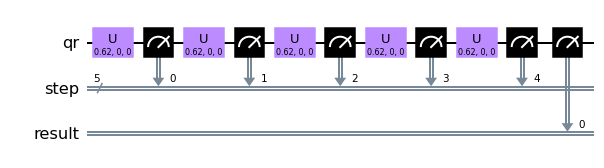

In [73]:
bomb = bomb_oracle()
qc = gen_circuit(0.5, bomb)
qc.draw(output='mpl')

We provide the `em` method below to allow you to easily emulate your circuit.

In [74]:
qasm_sim = BasicAer.get_backend("qasm_simulator")

def em(qc, shots=1024):
    job = execute(qc, qasm_sim, shots=shots)
    counts = job.result().get_counts()
    return counts

em(qc)

{'0 00000': 614,
 '1 10000': 74,
 '0 00111': 10,
 '0 00011': 11,
 '1 11000': 68,
 '1 11111': 62,
 '1 11110': 63,
 '1 11100': 60,
 '0 01110': 9,
 '0 00001': 10,
 '0 00010': 4,
 '0 01100': 9,
 '0 00110': 6,
 '0 01000': 7,
 '0 00100': 5,
 '1 10110': 4,
 '0 01111': 5,
 '1 11010': 1,
 '1 10011': 1,
 '1 11001': 1}

#### Task 5: 
Run your code a few times and observe the output. Regenerate your circuit until you get a different version. Run each circuit a few times and observe the output. Describe why we observe each respective output and what the output represents. Would you be able to tell if there was a bomb present just by observing the output? Be sure to note any abnormal behavior and explain potential reasons for it. Enter your answers into the cell below.

$|1\rangle$ represents the case of no bomb present and we'd expect to exclusively see $|1\rangle$ for a box with no bomb. If there is a bomb, we'd see it according to the probability established for the trial. $|0\rangle$ represents the expected state when a bomb is present.

#### For Fun
Feel free to play around with the code below. This won't count for anything.

In [84]:
def runCircuit(percentage,bomb):
    qc = gen_circuit(percentage,bomb)
    qc.draw(output="mpl")
    counts = em(qc)
    n = compute_iterations(percentage)
    
    
    zeros_key = "0 " + "0"*n
    one_key = "1 "+"0"*n
    
    predicted_bomb = 0
    predicted_no_bomb = 0
    blew_up = 0
    
    if zeros_key in counts:
        predicted_bomb = counts[zeros_key]
    if one_key in counts:
        predicted_no_bomb = counts[one_key]
        
    blew_up = 1024 - predicted_bomb - predicted_no_bomb
    #1024 is the default # of shots, must change above if using a different # of shots
    
    y = np.arange(3)
    plt.bar(y, [predicted_bomb, predicted_no_bomb, blew_up])
    plt.ylabel("Shots")
    plt.xticks(y, ["Predicted Bomb", "Predicted No Bomb", "Blew Up"])
    if bomb == "bomb":
        plt.title("EV Experiment Results with Bomb")
    else:
        plt.title("EV Experiment Results with No Bomb")
    plt.show()
    
    return None

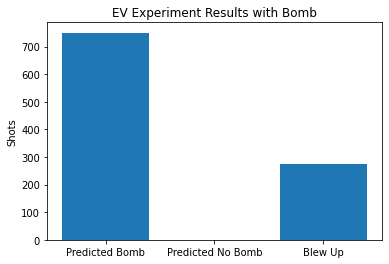

In [83]:
bomb = bombOracle()
runCircuit(0.7,bomb)

Next time: multi-qubit circuits!